We will now compare the models to test their performance compared to each other, the tests we will perform:
1. Accuracy as a function of number of epochs.
2. Accuracy as a number of data size.
3. Model performance of a data in which a sensor dropped out

First we will provide the helper functions to visualize and test the results, as well as data generation functions.

In [33]:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy import signal
from torch.utils.data import random_split
import torch.nn.functional as F
import copy
import scipy.ndimage as ndimage
import scipy.spatial.distance as dist_lib
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42)

In [2]:
# data generation

def generate_unified_data(num_samples=5000, grid_size=32, noise_level=0.001, dropout_prob=0.3, min_vel=280.0, max_vel=320.0, two_source_input_prob=0.5, wave_freq=5.0, time_steps=200):
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size)
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]]) # 4 Corners


    X_clean = np.zeros((num_samples, 4, time_steps))
    y_locs = np.full((num_samples, 2, 2), -1.0)
    n_sources = np.zeros(num_samples, dtype=int)

    t_wave = np.arange(time_steps) * dt
    f0 = wave_freq
    wavelet_base = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t_wave**2)) * np.exp(-(np.pi**2)*(f0**2)*(t_wave**2))
    wavelet_base = wavelet_base / np.max(np.abs(wavelet_base))


    for i in range(num_samples):
        vel = np.random.uniform(min_vel, max_vel)
        # randomly generate 1 or 2 sources sample
        num_src = 1 if np.random.rand() > two_source_input_prob else 2
        n_sources[i] = num_src

        current_signal = np.zeros((4, time_steps))

        for src_idx in range(num_src):
            src = np.random.rand(2) * [x_max, y_max]
            y_locs[i, src_idx] = src

            for s in range(4):
                dist = np.sqrt(np.sum((src - sensor_locs[s])**2))
                arrival_time = dist / vel
                shift_steps = int(arrival_time / dt)
                amplitude = 1.0 / (dist + 1.0)

                if shift_steps < time_steps:
                    valid_len = time_steps - shift_steps
                    current_signal[s, shift_steps:] += wavelet_base[:valid_len] * amplitude

        X_clean[i] = current_signal

    # teacher data part
    teacher_noise_tensor = np.random.normal(0, noise_level, X_clean.shape)
    X_teacher = X_clean + teacher_noise_tensor

    # student data part
    student_noise_tensor = np.random.normal(0, noise_level, X_clean.shape)
    X_student = X_clean + student_noise_tensor

    for i in range(num_samples):
        if np.random.rand() < dropout_prob:
            dead_sensor_idx = np.random.randint(0, 4)
            X_student[i, dead_sensor_idx, :] = 0.0

    return (
        torch.tensor(X_student, dtype=torch.float32),
        torch.tensor(X_teacher, dtype=torch.float32),
        torch.tensor(y_locs, dtype=torch.float32),
        torch.tensor(n_sources, dtype=torch.long)
    )

In [3]:
# gaussian map creator function

def create_mixed_gaussian_map(source_locs, grid_size=32, sigma=3.0):

    x = np.arange(grid_size)
    y = np.arange(grid_size)
    xx, yy = np.meshgrid(x, y)
    maps = []

    for i in range(len(source_locs)):
        # source 1
        cx1, cy1 = source_locs[i, 0]

        gauss1 = np.exp(-((xx - cx1)**2 + (yy - cy1)**2) / (2 * sigma**2))

        # source 2 if exists
        cx2, cy2 = source_locs[i, 1]

        # if there's only 1 source
        if cx2 == -1:
            combined = gauss1

        # if there are 2 sources
        else:
            gauss2 = np.exp(-((xx - cx2)**2 + (yy - cy2)**2) / (2 * sigma**2))
            combined = np.maximum(gauss1, gauss2)

        maps.append(combined)

    return np.array(maps)

In [79]:
def get_min_and_index(hist):
  for i, item in enumerate(hist):
    if item == np.min(hist):
      return i, item

In [67]:
# evaluating functions and plotting
def get_peak_location(heatmap, grid_size=32):
    idx = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    pixel_size = float(grid_size) / heatmap.shape[0]
    pred_y = idx[0] * pixel_size
    pred_x = idx[1] * pixel_size
    return np.array([pred_x, pred_y])

def calculate_accuracy(model, loader, device):
    model.eval()
    errors = []

    with torch.no_grad():
        # Note: We now unpack 5 items from the loader
        for inputs, _, true_coords, _, _ in loader:
            inputs = inputs.to(device)
            # true_coords shape: (batch_size, 2, 2)
            # - dim 1 is source index (source 0, source 1)
            # - dim 2 is (x, y)

            outputs = model(inputs).cpu().numpy()
            true_coords = true_coords.numpy()

            for i in range(len(inputs)):
                # Get prediction from model heatmap
                pred_loc = get_peak_location(outputs[i, 0])

                # Calculate distance to Source 0
                dist1 = np.linalg.norm(true_coords[i, 0] - pred_loc)

                valid_dists = [dist1]

                # Check if Source 1 exists (it will be -1,-1 if it doesn't)
                # We check if x coordinate is not -1
                if true_coords[i, 1, 0] != -1:
                    dist2 = np.linalg.norm(true_coords[i, 1] - pred_loc)
                    valid_dists.append(dist2)

                # The error is the distance to the *closest* valid source
                errors.append(min(valid_dists))

    return np.mean(errors)

In [5]:
def create_data_and_data_loaders(num_samples=5000, grid_size=32, noise_level=0.001, dropout_prob=0.3, min_vel=280.0, max_vel=320.0, two_source_input_prob=0.5, wave_freq=5.0, time_steps=200, sigma=3.0):
  X_s_raw, X_t_raw, Y_coords, n_sources = generate_unified_data(num_samples=num_samples, grid_size=grid_size, noise_level=noise_level,
                                                                dropout_prob=dropout_prob, min_vel=min_vel, max_vel=max_vel, two_source_input_prob=two_source_input_prob, wave_freq=wave_freq, time_steps=time_steps)

  Y_heatmaps_np = create_mixed_gaussian_map(Y_coords.numpy(), grid_size=32, sigma=sigma)
  Y_heatmaps = torch.tensor(Y_heatmaps_np, dtype=torch.float32).unsqueeze(1)

  # split 80/10/10
  N = len(X_s_raw)
  indices = torch.randperm(N)

  n_train = int(0.8 * N)
  n_val = int(0.1 * N)
  n_test = N - n_train - n_val

  train_idx = indices[:n_train]
  val_idx   = indices[n_train:n_train+n_val]
  test_idx  = indices[n_train+n_val:]

  # split all data
  X_s_train, X_s_val, X_s_test = X_s_raw[train_idx], X_s_raw[val_idx], X_s_raw[test_idx]
  X_t_train, X_t_val, X_t_test = X_t_raw[train_idx], X_t_raw[val_idx], X_t_raw[test_idx]

  Y_c_train, Y_c_val, Y_c_test = Y_coords[train_idx], Y_coords[val_idx], Y_coords[test_idx]
  Y_h_train, Y_h_val, Y_h_test = Y_heatmaps[train_idx], Y_heatmaps[val_idx], Y_heatmaps[test_idx]
  n_src_train, n_src_val, n_src_test = n_sources[train_idx], n_sources[val_idx], n_sources[test_idx]

  # normalize data
  norm_s = torch.max(torch.abs(X_s_train))
  X_s_train = X_s_train / norm_s
  X_s_val   = X_s_val   / norm_s
  X_s_test  = X_s_test  / norm_s

  # normalize teacher data
  norm_t = torch.max(torch.abs(X_t_train))
  X_t_train = X_t_train / norm_t
  X_t_val   = X_t_val   / norm_t
  X_t_test  = X_t_test  / norm_t

  # adding noise to the test set to test robustness
  fixed_noise = torch.randn(X_s_test.size()) * 0.005
  X_s_test = X_s_test + fixed_noise

  # creating dataloaders
  train_data = TensorDataset(X_s_train, X_t_train, Y_c_train, Y_h_train, n_src_train)
  val_data   = TensorDataset(X_s_val,   X_t_val,   Y_c_val,   Y_h_val,   n_src_val)
  test_data  = TensorDataset(X_s_test,  X_t_test,  Y_c_test,  Y_h_test,  n_src_test)

  train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
  val_loader   = DataLoader(val_data,   batch_size=64, shuffle=False)
  test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False)

  return train_loader, val_loader, test_loader

Next, we will define both models and the functions needed to train them

Starting with the CNN model

In [88]:
# model architecture
class WaveToMapNet(nn.Module):
    def __init__(self):
        super(WaveToMapNet, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(4, 32, 7, stride=2, padding=3), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Conv1d(32, 64, 5, stride=2, padding=2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 3, stride=2, padding=1), nn.BatchNorm1d(128), nn.ReLU(),
        )

        # linear layer
        self.bottleneck = nn.Sequential(
            nn.Linear(3200, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128 * 8 * 8),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)
        x = x.view(x.size(0), 128, 8, 8)
        x = self.decoder(x)
        return x

In [7]:
# helper layer to help the model avoid ghosting sources

class AddCoords(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_tensor):
        batch_size, _, length = input_tensor.size()
        coords = torch.linspace(-1, 1, length).to(input_tensor.device)
        coords = coords.view(1, 1, length).expand(batch_size, 1, length)

        return torch.cat([input_tensor, coords], dim=1)

In [8]:
class TeacherWaveToMapNet(nn.Module):
    def __init__(self):
        super(TeacherWaveToMapNet, self).__init__()
        self.coord_adder = AddCoords()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(5, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        # pooling
        self.global_pool = nn.AdaptiveAvgPool1d(25)

        # linear layer
        self.fc = nn.Linear(256 * 25, 128 * 16 * 16)

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.coord_adder(x)
        x = self.encoder(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, 16, 16)
        x = self.decoder(x)
        return x

In [9]:
def train_teacher(model, train_loader, val_loader, epochs=30, lr=0.001):
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
  criterion = nn.MSELoss()
  best_params = copy.deepcopy(model.state_dict())
  min_loss = float('inf')
  for epoch in range(epochs):
      model.train()
      running_loss = 0.0

      for _, inputs, _, target_heatmaps, n_src in train_loader:
          inputs, n_src, target_heatmaps = inputs.to(device), n_src.to(device), target_heatmaps.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, target_heatmaps)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      avg_loss = running_loss / len(train_loader)
      if (epoch+1) % 5 == 0:
          print(f"Teacher Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

  print("Training complete, Validating now")

  val_loss = 0.0
  model.eval()
  with torch.no_grad():
      for _, inputs, _, target_heatmaps, n_src in val_loader:
          inputs, n_src, target_heatmaps = inputs.to(device), n_src.to(device), target_heatmaps.to(device)
          val_loss += criterion(model(inputs), target_heatmaps).item()

  avg_val_loss = val_loss / len(val_loader)
  # save best params if this is the best validation loss
  if avg_val_loss < min_loss:
      best_params = copy.deepcopy(model.state_dict())
      min_loss = avg_val_loss

  print(f"Teacher Validation Loss: {avg_val_loss:.6f}")
  model.load_state_dict(best_params) # load best params

In [10]:
# at the start we should rely more heavily on the teacher, and over time (epochs), the studnet would rely more on itself
# this helper function implements this logic

def get_alpha(epoch, epochs):
  starting_alpha = 0.8
  min_alpha = 0.1 # the lowest we will go
  epoch_decay_limit = int(0.8 * epochs)
  if epoch >= epochs:
    return min_alpha

  progress = epoch / epoch_decay_limit
  return starting_alpha - (progress * (starting_alpha - min_alpha))

In [39]:
def train_student(model, teacher_model, train_loader, val_loader, test_loader, epochs=30, lr=0.001, save_best=False):
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  best_params = copy.deepcopy(model.state_dict())
  min_loss = float('inf')
  teacher_model.eval()
  acc = []
  for epoch in range(epochs):
    alpha = get_alpha(epoch, epochs)
    model.train()
    running_loss = 0.0

    for inputs, teacher_inputs, _, target_heatmaps, n_src in train_loader:
      inputs, teacher_inputs, n_src, target_heatmaps = inputs.to(device), teacher_inputs.to(device), n_src.to(device), target_heatmaps.to(device)

      # add noise to student inputs
      noise = torch.randn_like(inputs) * 0.005
      student_inputs = inputs + noise

      # teacher evaluation
      with torch.no_grad():
        teacher_preds = teacher_model(teacher_inputs)

      student_preds = model(student_inputs)

      # calculate loss
      loss_truth = criterion(student_preds, target_heatmaps)
      loss_distill = criterion(student_preds, teacher_preds)

      loss = (1 - alpha) * loss_truth + alpha * loss_distill

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    current_test_error = calculate_accuracy(model, test_loader, device)
    acc.append(current_test_error)

    if (epoch+1) % 5 == 0:
        print(f"Distill Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.6f}")

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
      for inputs, _, _, target_heatmaps, n_src in val_loader:
        inputs, n_src, target_heatmaps = inputs.to(device), n_src.to(device), target_heatmaps.to(device)
        val_loss += criterion(model(inputs), target_heatmaps).item()

    avg_val_loss = val_loss / len(val_loader)
    # save best params during training
    if avg_val_loss < min_loss:
      best_params = copy.deepcopy(model.state_dict())
      min_loss = avg_val_loss

  print(f"Student Validation Loss: {avg_val_loss:.6f}")

  model.load_state_dict(best_params) # load best params
  return acc

Next, the FNO model

In [91]:
class LearnableBasisNet_Simple(nn.Module):
  def __init__(self, num_sensors=4, time_steps=200, grid_size=32):
    super(LearnableBasisNet_Simple, self).__init__()
    self.grid_size = grid_size
    self.time_steps = time_steps

    self.hidden_dim = 128
    self.learnable_transform = nn.Linear(time_steps, self.hidden_dim)

    input_dim = num_sensors * self.hidden_dim

    self.spectral_mixer = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, grid_size * grid_size)
    )

  def forward(self, x):
    batch_size = x.size(0)
    x_flat = x.view(-1, self.time_steps)

    x_freq = self.learnable_transform(x_flat)
    x_freq = torch.relu(x_freq)

    x_freq = x_freq.view(batch_size, -1)
    x_spatial = self.spectral_mixer(x_freq)

    output_map = x_spatial.view(batch_size, 1, self.grid_size, self.grid_size)
    return output_map

In [58]:
def train_fno(model, train_loader, val_loader, test_loader, epochs=30, lr=0.001, save_best=False):
    opt_fno = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    acc = []
    best_loss = float('inf')
    best_params = copy.deepcopy(model.state_dict())
    for epoch in range(epochs):
      model.train()
      running_loss = 0.0

      for _, inputs, _, target_heatmaps, _ in train_loader:
        inputs, target_heatmaps = inputs.to(device), target_heatmaps.to(device)

        noise = torch.randn_like(inputs) * 0.005
        inputs = inputs + noise

        opt_fno.zero_grad()
        pred = model(inputs)
        loss = criterion(pred, target_heatmaps)
        loss.backward()
        opt_fno.step()

        running_loss += loss.item()


      current_test_error = calculate_accuracy(model, test_loader, device)
      acc.append(current_test_error)

      # Print loss every 5 epochs
      if (epoch + 1) % 5 == 0:
          print(f"FNO Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.6f}")

      if save_best:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
          for _, inputs, _, target_heatmaps, _ in val_loader:
            inputs, target_heatmaps = inputs.to(device), target_heatmaps.to(device)
            pred = model(inputs)
            val_loss += criterion(pred, target_heatmaps).item()

        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_loss:
          best_loss = avg_val_loss
          best_params = copy.deepcopy(model.state_dict())



    return acc

Now we will start with test #1 : Testing accuracy as a function of number of epochs. This simulates a case where you need to decide which model to use for this task when you have limited computational resources.

In [82]:
def plot_results(cnn_history, fno_history):
    epochs = len(cnn_history)
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(10, 6))

    # CNN part
    plt.plot(epochs_range, cnn_history, label='CNN Student', marker='o', linestyle='--', color='blue')

    # FNO part
    plt.plot(epochs_range, fno_history, label='FNO', marker='s', linestyle='-', color='orange')

    plt.title("Model Accuracy Comparison")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Mean Position Error (Meters)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Data generation parameters

In [72]:
# data params
num_samples = 5000
grid_size = 32
noise_level = 0.01 # noise that will be added on generation to all data, we add more noise during training to the FNO and CNN model
dropout_prob = 0.3 # probability that a sensor is dropped in a single data simple
two_source_input_prob = 0.5 # probability that a sample will be a one source sample, rather than a two source sample
time_steps = 200

# data physical parameters
wave_freq = 5.0 # in Hz
sigma = 3.0 # gaussian sigma
# velocity is generated randomly (uniform dist) between the min and max values below
min_vel = 280.0 # meters / seconds
max_vel = 320.0 # meters / seconds

In [73]:
train_loader, val_loader, test_loader = create_data_and_data_loaders(num_samples, grid_size, noise_level, dropout_prob, min_vel, max_vel, two_source_input_prob, wave_freq, time_steps, sigma)

Choose the desired number of epochs to test, either way, the teacher will be trained for 30 epochs

In [17]:
total_epochs = 40

In [74]:
teacher = TeacherWaveToMapNet().to(device)
train_teacher(teacher, train_loader, val_loader, epochs=30)

Teacher Epoch 5/30 | Loss: 0.008074
Teacher Epoch 10/30 | Loss: 0.006271
Teacher Epoch 15/30 | Loss: 0.005394
Teacher Epoch 20/30 | Loss: 0.004588
Teacher Epoch 25/30 | Loss: 0.003958
Teacher Epoch 30/30 | Loss: 0.003550
Training complete, Validating now
Teacher Validation Loss: 0.007279


In [89]:
cnn = WaveToMapNet().to(device)
cnn_history = train_student(cnn, teacher, train_loader, val_loader, test_loader, total_epochs)

Distill Epoch 5/40 | Loss: 0.010555
Distill Epoch 10/40 | Loss: 0.005271
Distill Epoch 15/40 | Loss: 0.003617
Distill Epoch 20/40 | Loss: 0.002948
Distill Epoch 25/40 | Loss: 0.002565
Distill Epoch 30/40 | Loss: 0.002197
Distill Epoch 35/40 | Loss: 0.001887
Distill Epoch 40/40 | Loss: 0.001399
Student Validation Loss: 0.010115


In [92]:
fno = LearnableBasisNet_Simple().to(device)
fno_history = train_fno(fno, train_loader, val_loader, test_loader, total_epochs)

FNO Epoch 5/40 | Loss: 0.024469
FNO Epoch 10/40 | Loss: 0.016333
FNO Epoch 15/40 | Loss: 0.015833
FNO Epoch 20/40 | Loss: 0.015768
FNO Epoch 25/40 | Loss: 0.015805
FNO Epoch 30/40 | Loss: 0.015705
FNO Epoch 35/40 | Loss: 0.015690
FNO Epoch 40/40 | Loss: 0.015667


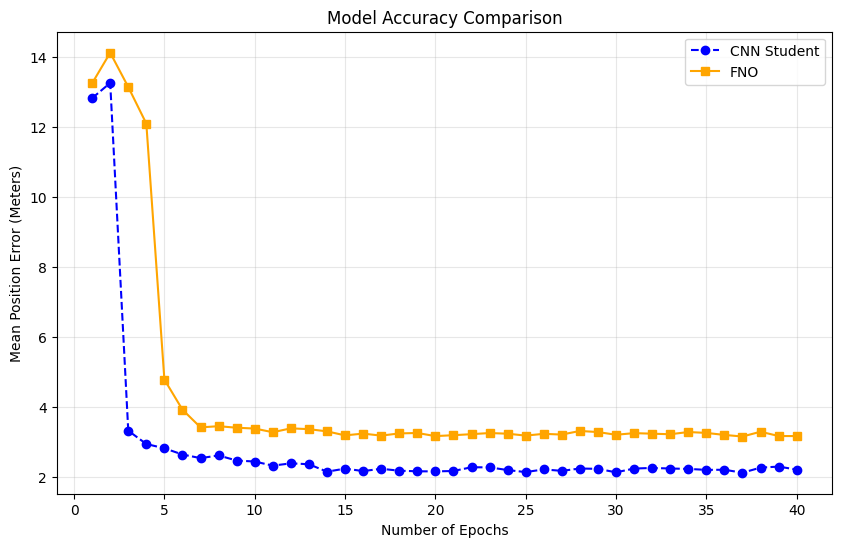

In [93]:
plot_results(cnn_history, fno_history)

In [94]:
cnn_best_epoch, cnn_lowest = get_min_and_index(cnn_history)
fno_best_epoch, fno_lowest = get_min_and_index(fno_history)

print(f"CNN best epoch was {cnn_best_epoch} with a lowest error of {cnn_lowest}")
print(f"FNO best epoch was {fno_best_epoch} with a lowest error of {fno_lowest}")

CNN best epoch was 36 with a lowest error of 2.13016381302672
FNO best epoch was 36 with a lowest error of 3.1628390539979288


In [95]:
def get_model_size_and_n_params(model, model_name):
  num_trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  param_size = 0
  for param in model.parameters():
    param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
  size_all_mb = (param_size + buffer_size) / 1024 ** 2
  print(f"{model_name} size: {size_all_mb:.2f} MB")
  print(f"number of trainable params: {num_trainable_params}")
  return size_all_mb, num_trainable_params

In [96]:
teacher_size, teacher_params = get_model_size_and_n_params(teacher, "Teacher Model")
print("=" * 50)
CNN_size, CNN_params = get_model_size_and_n_params(cnn, "CNN Student Model")
print("=" * 50)
FNO_size, FNO_params = get_model_size_and_n_params(fno, "FNO Model")

Teacher Model size: 801.25 MB
number of trainable params: 210040897
CNN Student Model size: 12.10 MB
number of trainable params: 3171713
FNO Model size: 10.11 MB
number of trainable params: 2650240


In [97]:
print(f"ratio between CNN and FNO params is {CNN_params / FNO_params}")
print(f"ratio between CNN and FNO size is {CNN_size / FNO_size}")

ratio between CNN and FNO params is 1.1967644439748852
ratio between CNN and FNO size is 1.1970836603477422


As we can see, after about 3 epochs the FNO reaches its very low accuracy (the best is reached after ~35 epochs), and thats without even needing a teacher smart model and with 3.6 times less the cnn model number parameters and size

Moving on to the 2nd test: accuracy as a function of the size of the data.

For each amount of samples we will re-train all 3 models (teacher, student, fno), this will simulate a case in which you have different amounts of data to train your models with

In [98]:
def run_efficiency_experiments(train_pool, val_dataset, test_tensors, sample_sizes, epochs=20):

    # Unpack fixed sets
    X_pool, X_t_pool, Y_c_pool, Y_h_pool, n_src_pool = train_pool
    X_test_clean, Y_coords_test, Y_heatmaps_test = test_tensors

    # Prepare Loaders
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Prepare Test Loader (Fixed Noise)
    # We add noise ONCE so every model fights the exact same noise
    noise = torch.randn(X_test_clean.size()) * 0.005
    X_test_noisy = X_test_clean + noise
    test_dataset = TensorDataset(X_test_noisy, torch.zeros_like(X_test_noisy), Y_coords_test, Y_heatmaps_test, torch.zeros(len(Y_coords_test)))
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # --- PHASE 1: Train The "Oracle" Teacher ---
    # The teacher learns from the FULL pool (e.g. 8000 samples)
    print(f"\n{'='*40}\nTraining Global Teacher (Oracle)\n{'='*40}")
    teacher = TeacherWaveToMapNet().to(device)

    # Create full pool loader
    full_train_dataset = TensorDataset(*train_pool)
    full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)

    train_teacher(teacher, full_train_loader, val_loader, epochs=epochs) # Train once!
    teacher.eval() # Freeze teacher

    results = {'sizes': [], 'cnn_acc': [], 'fno_acc': []}

    # --- PHASE 2: Train Students on Subsets ---
    for size in sample_sizes:
        print(f"\nExperiment: Subset Size = {size}")

        # Slicing from the POOL guarantees no overlap with Validation or Test
        if size > len(X_pool):
            print(f"Warning: Requested size {size} is larger than training pool {len(X_pool)}")
            size = len(X_pool)

        subset_dataset = TensorDataset(
            X_pool[:size], X_t_pool[:size], Y_c_pool[:size], Y_h_pool[:size], n_src_pool[:size]
        )
        subset_loader = DataLoader(subset_dataset, batch_size=64, shuffle=True)

        # Initialize Students
        cnn_student = WaveToMapNet().to(device)
        fno_student = LearnableBasisNet_Simple().to(device)

        # Train
        print(f"Training CNN Student (Distilled from Oracle)...")
        # Pass the GLOBAL teacher
        cnn_hist = train_student(cnn_student, teacher, subset_loader, val_loader, test_loader, epochs=epochs)

        print(f"Training FNO...")
        fno_hist = train_fno(fno_student, subset_loader, val_loader, test_loader, epochs=epochs)

        # Log
        results['sizes'].append(size)
        results['cnn_acc'].append(np.min(cnn_hist))
        results['fno_acc'].append(np.min(fno_hist))

    return results

In [103]:
def setup_global_experiment(total_samples=10000, val_size=1000, epochs=30, two_source_input_prob=0.5):
    test_size = val_size
    X_s_raw, X_t_raw, Y_coords, n_src_raw = generate_unified_data(num_samples=total_samples, two_source_input_prob=two_source_input_prob)

    Y_heatmaps_np = create_mixed_gaussian_map(Y_coords.numpy())
    Y_heatmaps = torch.tensor(Y_heatmaps_np, dtype=torch.float32).unsqueeze(1)

    norm_s = torch.max(torch.abs(X_s_raw))
    norm_t = torch.max(torch.abs(X_t_raw))

    X_s_norm = X_s_raw / norm_s
    X_t_norm = X_t_raw / norm_t

    global_data = (X_s_norm, X_t_norm, Y_coords, Y_heatmaps, n_src_raw)

    n_reserved = val_size + test_size
    n_train_pool = total_samples - n_reserved

    # Create the POOL for training (0 to 8000)
    # The teacher sees ALL of this. Students see subsets of this.
    train_pool_tensors = (
        X_s_norm[:n_train_pool],
        X_t_norm[:n_train_pool],
        Y_coords[:n_train_pool],
        Y_heatmaps[:n_train_pool],
        n_src_raw[:n_train_pool]
    )

    # Create Validation Set (8000 to 9000)
    val_dataset = TensorDataset(
        X_s_norm[n_train_pool : n_train_pool+val_size],
        X_t_norm[n_train_pool : n_train_pool+val_size],
        Y_coords[n_train_pool : n_train_pool+val_size],
        Y_heatmaps[n_train_pool : n_train_pool+val_size],
        n_src_raw[n_train_pool : n_train_pool+val_size]
    )

    # Create Test Set (9000 to 10000)
    # Return raw tensors for test so we can add noise later in the loop if needed
    test_tensors = (
        X_s_norm[-test_size:],
        Y_coords[-test_size:],
        Y_heatmaps[-test_size:]
    )

    return train_pool_tensors, val_dataset, test_tensors

In [110]:
def plot_sample_efficiency(results):
    plt.figure(figsize=(10, 6))
    plt.plot(results['sizes'], results['cnn_acc'], marker='o', label='CNN Student')
    plt.plot(results['sizes'], results['fno_acc'], marker='s', label='FNO')

    plt.title("Sample Efficiency Comparison")
    plt.xlabel("Number of Training Samples")
    plt.ylabel("Mean Position Error (Meters)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Here you can modify the sample sized which will be tested

In [105]:
chosen_sample_sizes = [1000, 2000, 3000, 5000, 10000]
chosen_epochs = 15
two_source_input_prob = 0.5

In [106]:
train_pool, val_dataset, test_tensors = setup_global_experiment(total_samples=int(np.round(chosen_sample_sizes[-1] * 1.2)), two_source_input_prob=two_source_input_prob)

In [107]:
results = run_efficiency_experiments(train_pool, val_dataset, test_tensors, sample_sizes = chosen_sample_sizes, epochs=chosen_epochs)


Training Global Teacher (Oracle)
Teacher Epoch 5/15 | Loss: 0.005010
Teacher Epoch 10/15 | Loss: 0.004308
Teacher Epoch 15/15 | Loss: 0.003931
Training complete, Validating now
Teacher Validation Loss: 0.004362

Experiment: Subset Size = 1000
Training CNN Student (Distilled from Oracle)...
Distill Epoch 5/15 | Loss: 0.052619
Distill Epoch 10/15 | Loss: 0.028587
Distill Epoch 15/15 | Loss: 0.019781
Student Validation Loss: 0.018475
Training FNO...
FNO Epoch 5/15 | Loss: 0.031231
FNO Epoch 10/15 | Loss: 0.028968
FNO Epoch 15/15 | Loss: 0.027144

Experiment: Subset Size = 2000
Training CNN Student (Distilled from Oracle)...
Distill Epoch 5/15 | Loss: 0.036615
Distill Epoch 10/15 | Loss: 0.015768
Distill Epoch 15/15 | Loss: 0.012359
Student Validation Loss: 0.011758
Training FNO...
FNO Epoch 5/15 | Loss: 0.029987
FNO Epoch 10/15 | Loss: 0.022367
FNO Epoch 15/15 | Loss: 0.017186

Experiment: Subset Size = 3000
Training CNN Student (Distilled from Oracle)...
Distill Epoch 5/15 | Loss: 0.019

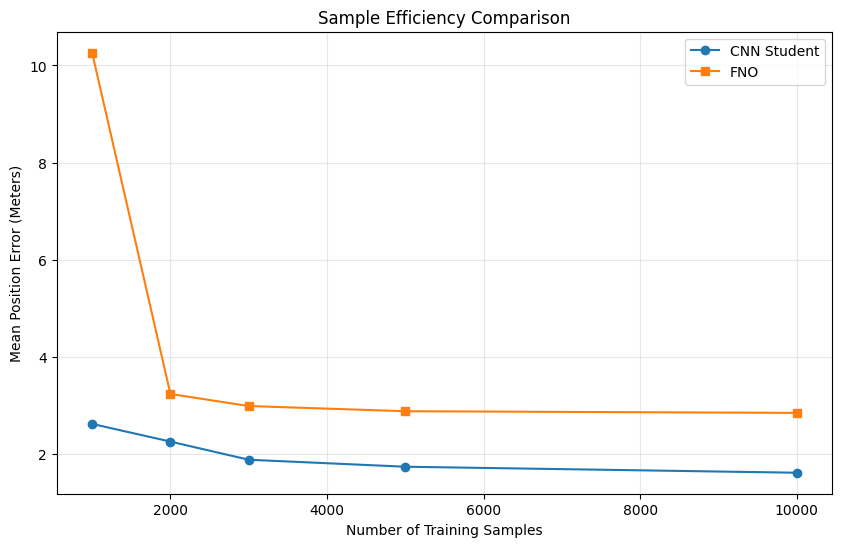

In [111]:
plot_sample_efficiency(results)

Again we see that for every number of data size you might have, its better to use the FNO.

Now we will check what happens when you train your models on clean data, but then in the "money-time" one of the sensors is malfunctioning, meaning it provides no data at all or very noisy data

In [112]:
def create_malfunction_loader(original_loader, target_sensor_idx=0, high_noise_level=0.1):
    malfunction_data = []

    for inputs, t_in, coords, hmaps, n_src in original_loader:

        # create a copy of the inputs to have a clean and corrupt one
        corrupt_inputs = inputs.clone()

        batch_size = inputs.shape[0]

        # random mask for the malfunctioning sensor
        is_dead_mask = torch.rand(batch_size) > 0.5

        for i in range(batch_size):
            if is_dead_mask[i]:
                # dead sensor case
                corrupt_inputs[i, target_sensor_idx, :] = 0.0
            else:
                # high noise case
                noise = torch.randn_like(corrupt_inputs[i, target_sensor_idx, :]) * high_noise_level
                corrupt_inputs[i, target_sensor_idx, :] += noise

        malfunction_data.append((corrupt_inputs, t_in, coords, hmaps, n_src))

    return malfunction_data

In [113]:
def plot_robustness_comparison(c_clean, c_broken, f_clean, f_broken):
  labels = ['Standard Test Set', 'Malfunction Test Set']
  cnn_scores = [c_clean, c_broken]
  fno_scores = [f_clean, f_broken]

  x = np.arange(len(labels))
  width = 0.35

  plt.figure(figsize=(8, 6))
  plt.bar(x - width/2, cnn_scores, width, label='CNN Student', color='royalblue')
  plt.bar(x + width/2, fno_scores, width, label='FNO', color='darkorange')

  plt.ylabel('Mean Position Error (Meters)')
  plt.title('Robustness to Sensor Malfunction (Dead/Noisy) - 1 Wave Source')
  plt.xticks(x, labels)
  plt.legend()
  plt.grid(axis='y', alpha=0.3)
  plt.show()

In [114]:
def run_sensor_malfunction_experiment(total_samples=5000, epochs=20, sensor_idx=0):
  # helper function to create data loaders
  # def create_loader(s_slice, shuffle):
  #   # Normalize
  #   x_s = X_s_raw[s_slice].clone() / norm_s
  #   x_t = X_t_raw[s_slice].clone() / norm_t
  #   data = TensorDataset(x_s, x_t, Y_coords[s_slice], Y_heatmaps[s_slice], n_src_raw[s_slice])
  #   return DataLoader(data, batch_size=64, shuffle=shuffle)


  print(f"\n{'='*60}\nRunning Sensor Malfunction Robustness Test\n{'='*60}")

  # generate data
  # X_s_raw, X_t_raw, Y_coords, n_src_raw = generate_unified_data(num_samples=total_samples, dropout_prob=0)
  # Y_heatmaps_np = create_mixed_gaussian_map(Y_coords.numpy())
  # Y_heatmaps = torch.tensor(Y_heatmaps_np, dtype=torch.float32).unsqueeze(1)

  # split into train, val, test, 80/10/10
  # train_size = int(0.8 * total_samples)
  # val_size = int(0.10 * total_samples)

  # train_sl = slice(0, train_size)
  # val_sl   = slice(train_size, train_size + val_size)
  # test_sl  = slice(train_size + val_size, total_samples)

  # # normaliztion factor
  # norm_s = torch.max(torch.abs(X_s_raw[train_sl]))
  # norm_t = torch.max(torch.abs(X_t_raw[train_sl]))

  # creating loaders
  train_loader, val_loader, test_loader = create_data_and_data_loaders(num_samples, grid_size, noise_level, dropout_prob, min_vel, max_vel, two_source_input_prob, wave_freq, time_steps, sigma)
  # train_loader = create_loader(train_sl, shuffle=True)
  # val_loader   = create_loader(val_sl, shuffle=False)
  # test_loader  = create_loader(test_sl, shuffle=False)

  # train models on clean data
  print("Training models on clean data")
  teacher = TeacherWaveToMapNet().to(device)
  cnn = WaveToMapNet().to(device)
  fno = LearnableBasisNet_Simple().to(device)

  train_teacher(teacher, train_loader, val_loader, epochs=epochs)
  print("Teacher Trained")

  train_student(cnn, teacher, train_loader, val_loader, test_loader, epochs=epochs)
  print("CNN Student Trained")

  train_fno(fno, train_loader, val_loader, test_loader, epochs=epochs)
  print(" FNO Trained")

  # create corrupted data
  print(f"\n Generating Malfunction Test Set (Sensor {sensor_idx} -> Dead/Noisy)...")
  malfunction_loader = create_malfunction_loader(test_loader, target_sensor_idx=sensor_idx, high_noise_level=0.5)

  print("\n Evaluating...")

  # check accuracy on the clean dataset
  acc_cnn_clean = calculate_accuracy(cnn, test_loader, device)
  acc_fno_clean = calculate_accuracy(fno, test_loader, device)

  # check accuracy on the corrupted dataset
  acc_cnn_broken = calculate_accuracy(cnn, malfunction_loader, device)
  acc_fno_broken = calculate_accuracy(fno, malfunction_loader, device)

  # plot
  print(f"\nResults Summary:")
  print(f"CNN | Clean Error: {acc_cnn_clean:.2f}m | Broken Sensor Error: {acc_cnn_broken:.2f}m")
  print(f"FNO | Clean Error: {acc_fno_clean:.2f}m | Broken Sensor Error: {acc_fno_broken:.2f}m")

  return acc_cnn_clean, acc_cnn_broken, acc_fno_clean, acc_fno_broken


Choose which sensor to fail and the number of epochs the models will train

In [115]:
chosen_epochs_2 = 20
sensor_index = 1 # should be one of 0,1,2,3
total_samples_2 = 5000

In [116]:
acc_cnn_clean, acc_cnn_broken, acc_fno_clean, acc_fno_broken = run_sensor_malfunction_experiment(total_samples = total_samples_2, epochs=chosen_epochs_2, sensor_idx=sensor_index)


Running Sensor Malfunction Robustness Test
Training models on clean data
Teacher Epoch 5/20 | Loss: 0.008568
Teacher Epoch 10/20 | Loss: 0.006496
Teacher Epoch 15/20 | Loss: 0.005428
Teacher Epoch 20/20 | Loss: 0.004743
Training complete, Validating now
Teacher Validation Loss: 0.007738
Teacher Trained
Distill Epoch 5/20 | Loss: 0.017163
Distill Epoch 10/20 | Loss: 0.010527
Distill Epoch 15/20 | Loss: 0.008380
Distill Epoch 20/20 | Loss: 0.007242
Student Validation Loss: 0.009985
CNN Student Trained
FNO Epoch 5/20 | Loss: 0.027832
FNO Epoch 10/20 | Loss: 0.017578
FNO Epoch 15/20 | Loss: 0.016354
FNO Epoch 20/20 | Loss: 0.016270
 FNO Trained

 Generating Malfunction Test Set (Sensor 1 -> Dead/Noisy)...

 Evaluating...

Results Summary:
CNN | Clean Error: 2.17m | Broken Sensor Error: 9.28m
FNO | Clean Error: 3.19m | Broken Sensor Error: 6.90m


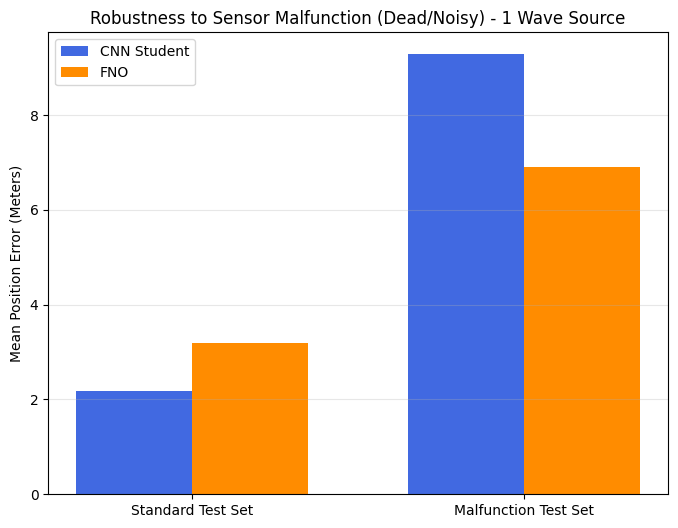

In [117]:
plot_robustness_comparison(acc_cnn_clean, acc_cnn_broken, acc_fno_clean, acc_fno_broken)

Finally the CNN is better at something, it beats the FNO on noisy data regarding mean accuracy by ~1.7 meters when one of the sensors is malfunctioning

Now we will check the performance of each model based on the level of noise the data contains

In [123]:
def run_noise_robustness_test(cnn_model, fno_model, num_samples=5000):
    """
    Tests models on the EXACT same physics, but with increasing noise levels.
    """
    # 1. Define Noise Levels (Standard Deviation)
    # 0.0 = Perfect Clean Data
    # 0.01 = Low Noise
    # 0.1 = Extreme Noise (100x base level)
    noise_levels = [0.0, 0.005, 0.01, 0.05, 0.1]

    results = {
        'noise_levels': noise_levels,
        'cnn_errors': [],
        'fno_errors': []
    }

    print(f"Generating Base Physics ({num_samples} samples)...")
    # Generate CLEAN data (noise_level=0.0) to start with
    # We disable dropout here to isolate Gaussian Noise effect
    X_s_clean, _, Y_coords, _ = generate_unified_data(
        num_samples=num_samples,
        noise_level=0.01,
        dropout_prob=0.3,
        two_source_input_prob=0.5,
        time_steps=200
    )

    # Pre-calculate Normalization (based on clean data max)
    norm_val = torch.max(torch.abs(X_s_clean))
    X_s_clean = X_s_clean / norm_val

    # Generate heatmaps from coordinates (required by calculate_accuracy)
    Y_heatmaps_np = create_mixed_gaussian_map(Y_coords.numpy())
    Y_heatmaps = torch.tensor(Y_heatmaps_np, dtype=torch.float32).unsqueeze(1)

    print(f"{'='*50}")
    print(f"Starting Noise Robustness Test")
    print(f"{'='*50}")

    for noise_std in noise_levels:
        print(f"Testing Noise Level: {noise_std}...", end="")

        # --- 2. Create Noisy Version ---
        # We use a fixed seed for reproducibility if you run this cell twice
        g_cpu = torch.Generator()
        g_cpu.manual_seed(42)

        # Add noise to the normalized clean data
        noise = torch.randn(X_s_clean.size(), generator=g_cpu) * noise_std
        X_test_noisy = X_s_clean + noise

        # Create Dataset
        test_dataset = TensorDataset(
            X_test_noisy,
            torch.zeros_like(X_test_noisy), # Dummy teacher input
            Y_coords,
            Y_heatmaps,
            torch.zeros(len(Y_coords))      # Dummy n_src
        )

        # Create Loader
        # We dummy the other tensors since we only need X and Y for testing
        # We dummy the other tensors since we only need X and Y_heatmaps for testing
        current_test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        # --- 3. Evaluate CNN ---
        # Ensure model is in eval mode (turns off dropout layers inside the model)
        cnn_err = calculate_accuracy(cnn_model, current_test_loader, device)
        results['cnn_errors'].append(cnn_err)

        # --- 4. Evaluate FNO ---
        fno_err = calculate_accuracy(fno_model, current_test_loader, device)
        results['fno_errors'].append(fno_err)

        print(f" Done. (CNN: {cnn_err:.2f}m | FNO: {fno_err:.2f}m)")

    return results

In [119]:
def plot_noise_robustness(results):
    levels = results['noise_levels']
    cnn_err = results['cnn_errors']
    fno_err = results['fno_errors']

    plt.figure(figsize=(10, 6))

    plt.plot(levels, cnn_err, 'o--', label='CNN Student', color='blue', linewidth=2)
    plt.plot(levels, fno_err, 's-', label='FNO Student', color='orange', linewidth=2)

    plt.title("Model Robustness: Accuracy vs. Noise Level", fontsize=14)
    plt.xlabel("Noise Standard Deviation ($\sigma$)", fontsize=12)
    plt.ylabel("Mean Position Error (Meters)", fontsize=12)

    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

    plt.axvline(x=0.05, color='green', linestyle=':', label='Training Noise Level (0.05)')
    plt.legend()

    plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2444891981.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("Noise Standard Deviation ($\sigma$)", fontsize=12)


Generating Base Physics (5000 samples)...
Starting Noise Robustness Test
Testing Noise Level: 0.0... Done. (CNN: 2.07m | FNO: 3.12m)
Testing Noise Level: 0.005... Done. (CNN: 2.11m | FNO: 3.14m)
Testing Noise Level: 0.01... Done. (CNN: 2.32m | FNO: 3.22m)
Testing Noise Level: 0.05... Done. (CNN: 9.66m | FNO: 4.66m)
Testing Noise Level: 0.1... Done. (CNN: 12.55m | FNO: 7.48m)


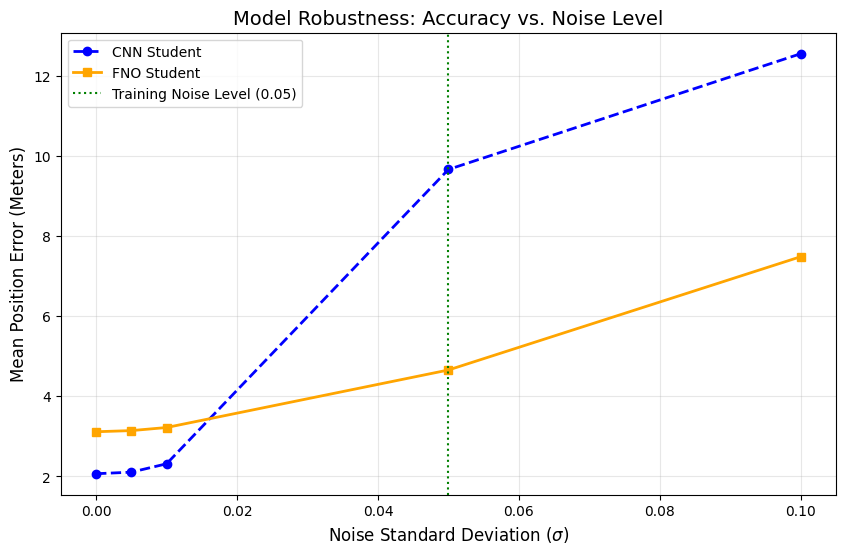

In [124]:
# 1. Run the test
noise_results = run_noise_robustness_test(cnn, fno, num_samples=5000)

# 2. Plot
plot_noise_robustness(noise_results)

We will now check to see the behaviour of the CNN vs the FNO model without the help of the teacher model, for that, we will define a new CNN student with the same architecture and parameters, but with a modified train function which will not account on the Teacher

In [139]:
def train_self_studying_student(model, train_loader, val_loader, test_loader, epochs=30, lr=0.001, save_best=False):
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  best_params = copy.deepcopy(model.state_dict())
  min_loss = float('inf')
  acc = []
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, teacher_inputs, _, target_heatmaps, n_src in train_loader:
      inputs, teacher_inputs, n_src, target_heatmaps = inputs.to(device), teacher_inputs.to(device), n_src.to(device), target_heatmaps.to(device)

      # add noise to student inputs
      noise = torch.randn_like(inputs) * 0.005
      student_inputs = inputs + noise

      student_preds = model(student_inputs)

      # calculate loss
      loss_truth = criterion(student_preds, target_heatmaps)

      loss = loss_truth

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    current_test_error = calculate_accuracy(model, test_loader, device)
    acc.append(current_test_error)

    if (epoch+1) % 5 == 0:
        print(f"Distill Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.6f}")

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
      for inputs, _, _, target_heatmaps, n_src in val_loader:
        inputs, n_src, target_heatmaps = inputs.to(device), n_src.to(device), target_heatmaps.to(device)
        val_loss += criterion(model(inputs), target_heatmaps).item()

    avg_val_loss = val_loss / len(val_loader)
    # save best params during training
    if avg_val_loss < min_loss:
      best_params = copy.deepcopy(model.state_dict())
      min_loss = avg_val_loss

  print(f"Student Validation Loss: {avg_val_loss:.6f}")

  model.load_state_dict(best_params) # load best params
  return acc

Lets perform a simple test comparing the new CNN, the old one (the one with teacher) and the FNO, we will let each of them train for 30 epochs

In [129]:
final_test_epochs = 30

In [140]:
def run_three_model_comparison(teacher, train_loader, val_loader, test_loader, epochs=30):
    print(f"{'='*60}\nStarting 3-Model Comparison (Epochs: {epochs})\n{'='*60}")

    teacher.eval() # Freeze teacher

    # --- 2. Train CNN Student (With Distillation) ---
    print(f"\nTraining CNN Student (Distillation)...")
    cnn_student = WaveToMapNet().to(device)
    # Re-using your existing train_student function
    # Ensure train_student returns the list of test accuracies!
    hist_student = train_student(cnn_student, teacher, train_loader, val_loader, test_loader, epochs=epochs, save_best=True)

    # --- 3. Train FNO (Standard) ---
    print(f"\nTraining FNO...")
    fno_model = LearnableBasisNet_Simple().to(device)
    # Re-using your existing train_fno function
    hist_fno = train_fno(fno_model, train_loader, val_loader, test_loader, epochs=epochs, save_best=True)

    # --- 4. Train Standalone CNN (No Teacher) ---
    print(f"\nTraining Standalone CNN (No Teacher)...")
    cnn_standalone = WaveToMapNet().to(device)
    hist_standalone = train_self_studying_student(cnn_standalone, train_loader, val_loader, test_loader, epochs=epochs, save_best=True)

    return hist_student, hist_fno, hist_standalone

In [135]:
def plot_three_models(student_hist, fno_hist, standalone_hist):
    epochs = len(student_hist)
    x_axis = range(1, epochs + 1)

    plt.figure(figsize=(10, 6))

    # Plot all 3
    plt.plot(x_axis, student_hist, label='CNN Student (Distilled)', color='blue', linestyle='--')
    plt.plot(x_axis, standalone_hist, label='CNN Standalone (No Teacher)', color='green', linestyle='-')
    plt.plot(x_axis, fno_hist, label='FNO', color='orange', linestyle='-.')

    plt.xlabel('Epochs')
    plt.ylabel('Mean Position Error (Meters)')
    plt.title('Comparison: Distillation vs. Standalone vs. FNO')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [141]:
hist_student, hist_fno, hist_standalone = run_three_model_comparison(teacher, train_loader, val_loader, test_loader, epochs=30)

Starting 3-Model Comparison (Epochs: 30)

Training CNN Student (Distillation)...
Distill Epoch 5/30 | Loss: 0.014505
Distill Epoch 10/30 | Loss: 0.008667
Distill Epoch 15/30 | Loss: 0.006290
Distill Epoch 20/30 | Loss: 0.004737
Distill Epoch 25/30 | Loss: 0.004129
Distill Epoch 30/30 | Loss: 0.003493
Student Validation Loss: 0.009931

Training FNO...
FNO Epoch 5/30 | Loss: 0.020956
FNO Epoch 10/30 | Loss: 0.016131
FNO Epoch 15/30 | Loss: 0.015832
FNO Epoch 20/30 | Loss: 0.015712
FNO Epoch 25/30 | Loss: 0.015728
FNO Epoch 30/30 | Loss: 0.015692

Training Standalone CNN (No Teacher)...
Distill Epoch 5/30 | Loss: 0.015078
Distill Epoch 10/30 | Loss: 0.008696
Distill Epoch 15/30 | Loss: 0.006234
Distill Epoch 20/30 | Loss: 0.004775
Distill Epoch 25/30 | Loss: 0.004083
Distill Epoch 30/30 | Loss: 0.003581
Student Validation Loss: 0.009907


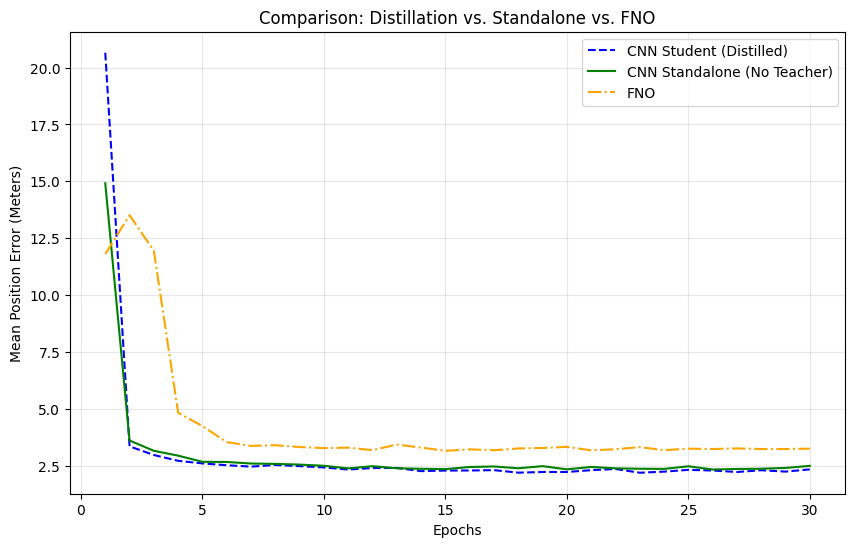

In [142]:
plot_three_models(hist_student, hist_fno, hist_standalone)

Looks like they perform almost the same, lets try to give them harder conditions

1. less data:

In [146]:
train_dataset = train_loader.dataset
subset_size = int(0.2 * len(train_dataset))
train_subset, _ = torch.utils.data.random_split(train_dataset, [subset_size, len(train_dataset)-subset_size])
small_train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
hist_student2, hist_fno2, hist_standalone2 = run_three_model_comparison(teacher, train_loader, val_loader, test_loader, epochs=30)

Starting 3-Model Comparison (Epochs: 30)

Training CNN Student (Distillation)...
Distill Epoch 5/30 | Loss: 0.020634
Distill Epoch 10/30 | Loss: 0.012012
Distill Epoch 15/30 | Loss: 0.008876
Distill Epoch 20/30 | Loss: 0.006845
Distill Epoch 25/30 | Loss: 0.005935
Distill Epoch 30/30 | Loss: 0.005170
Student Validation Loss: 0.010024

Training FNO...
FNO Epoch 5/30 | Loss: 0.021932
FNO Epoch 10/30 | Loss: 0.016132
FNO Epoch 15/30 | Loss: 0.015853
FNO Epoch 20/30 | Loss: 0.015769
FNO Epoch 25/30 | Loss: 0.015665
FNO Epoch 30/30 | Loss: 0.015652

Training Standalone CNN (No Teacher)...
Distill Epoch 5/30 | Loss: 0.015166
Distill Epoch 10/30 | Loss: 0.009228
Distill Epoch 15/30 | Loss: 0.006787
Distill Epoch 20/30 | Loss: 0.005430
Distill Epoch 25/30 | Loss: 0.004663
Distill Epoch 30/30 | Loss: 0.004111
Student Validation Loss: 0.009959


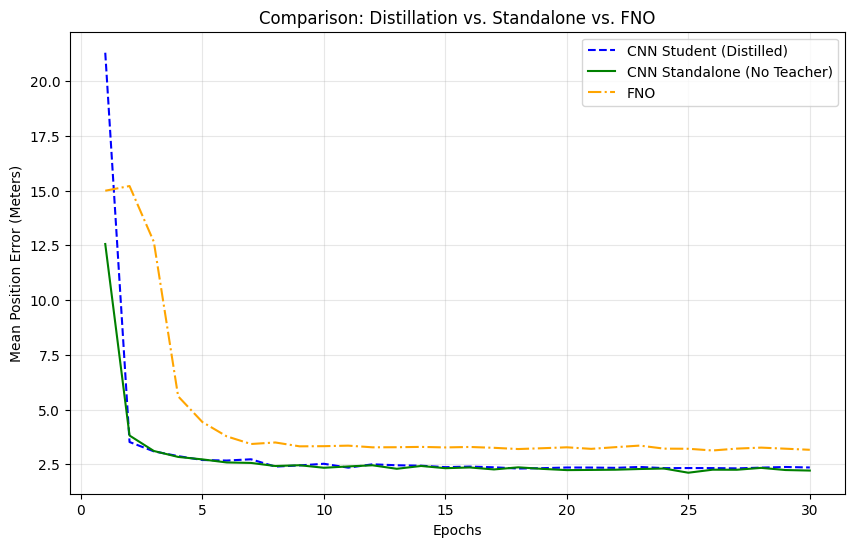

In [145]:
plot_three_models(hist_student2, hist_fno2, hist_standalone2)

2. add noise

In [147]:
def add_noise_to_loader(loader, noise_level=0.01):
    # 1. Access the underlying tensors from the existing loader
    # The dataset stores them in a tuple called .tensors
    # Order: (X_student, X_teacher, Y_coords, Y_heatmaps, n_src)
    X_s, X_t, Y_c, Y_h, n_src = loader.dataset.tensors

    # 2. Create Noise (same shape as Student Inputs X_s)
    # We clone X_s to avoid modifying the original data in memory if you need it later
    X_s_noisy = X_s.clone()
    noise = torch.randn_like(X_s_noisy) * noise_level

    # 3. Add Noise
    X_s_noisy += noise

    # 4. Create a NEW TensorDataset with the noisy inputs
    # We keep the other tensors (teacher, targets) exactly the same
    new_dataset = TensorDataset(X_s_noisy, X_t, Y_c, Y_h, n_src)

    # 5. Create a NEW DataLoader
    # Reuse the batch_size and shuffle settings from the original loader if possible
    new_loader = DataLoader(new_dataset, batch_size=loader.batch_size, shuffle=True)

    return new_loader

In [148]:
noisy_train_loader = add_noise_to_loader(train_loader, noise_level=0.05)

In [149]:
hist_student3, hist_fno3, hist_standalone3 = run_three_model_comparison(teacher, noisy_train_loader, val_loader, test_loader, epochs=30)

Starting 3-Model Comparison (Epochs: 30)

Training CNN Student (Distillation)...
Distill Epoch 5/30 | Loss: 0.022526
Distill Epoch 10/30 | Loss: 0.012091
Distill Epoch 15/30 | Loss: 0.006887
Distill Epoch 20/30 | Loss: 0.004781
Distill Epoch 25/30 | Loss: 0.003787
Distill Epoch 30/30 | Loss: 0.003067
Student Validation Loss: 0.020578

Training FNO...
FNO Epoch 5/30 | Loss: 0.022774
FNO Epoch 10/30 | Loss: 0.016294
FNO Epoch 15/30 | Loss: 0.015846
FNO Epoch 20/30 | Loss: 0.015746
FNO Epoch 25/30 | Loss: 0.015720
FNO Epoch 30/30 | Loss: 0.015669

Training Standalone CNN (No Teacher)...
Distill Epoch 5/30 | Loss: 0.020275
Distill Epoch 10/30 | Loss: 0.011289
Distill Epoch 15/30 | Loss: 0.006677
Distill Epoch 20/30 | Loss: 0.004888
Distill Epoch 25/30 | Loss: 0.003776
Distill Epoch 30/30 | Loss: 0.003181
Student Validation Loss: 0.015154


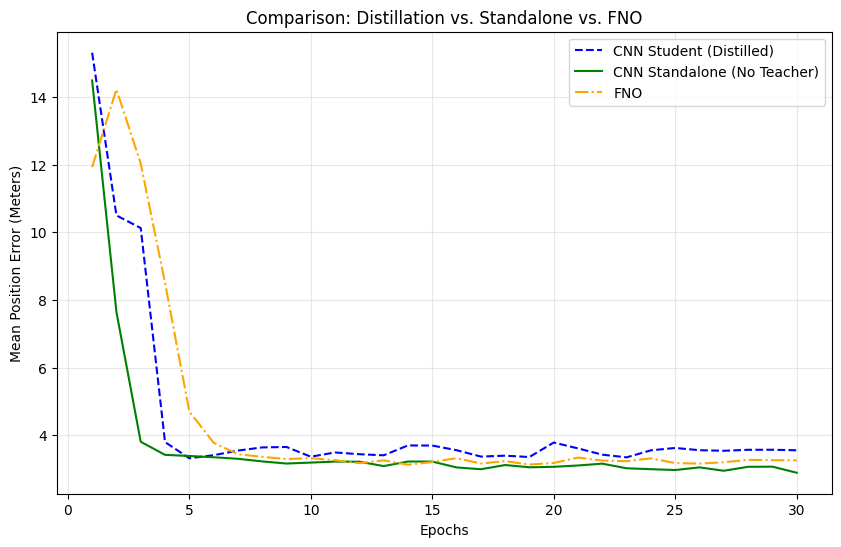

In [150]:
plot_three_models(hist_student3, hist_fno3, hist_standalone3)

3. Extreme test

In [153]:
def run_extreme_distillation_test(teacher, train_loader, val_loader, test_loader, epochs=30):
    # 1. Modify the Train Loop to use EXTREME Noise
    print("Running EXTREME Noise Test (Sigma=0.5)...")

    # --- Student (Distillation) ---
    cnn_student = WaveToMapNet().to(device)
    optimizer = optim.Adam(cnn_student.parameters(), lr=0.001)

    for epoch in range(epochs):
        cnn_student.train()
        for inputs, teacher_inputs, _, target_heatmaps, _ in train_loader:
            inputs, teacher_inputs = inputs.to(device), teacher_inputs.to(device)
            target_heatmaps = target_heatmaps.to(device)

            # EXTREME NOISE (The "Blindfold")
            # Noise is 100x stronger than before (0.5 vs 0.005)
            noise = torch.randn_like(inputs) * 0.5
            noisy_inputs = inputs + noise

            # Teacher sees CLEAN data (The "Guide")
            with torch.no_grad():
                teacher_preds = teacher(teacher_inputs)

            # Student sees NOISY data
            student_preds = cnn_student(noisy_inputs)

            # Distillation Loss
            loss = nn.MSELoss()(student_preds, teacher_preds)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    student_acc = calculate_accuracy(cnn_student, test_loader, device)
    print(f"Student (Distilled) Accuracy: {student_acc:.2f}m")

    # --- Standalone (No Teacher) ---
    cnn_standalone = WaveToMapNet().to(device)
    optimizer = optim.Adam(cnn_standalone.parameters(), lr=0.001)

    for epoch in range(epochs):
        cnn_standalone.train()
        for inputs, _, _, target_heatmaps, _ in train_loader:
            inputs, target_heatmaps = inputs.to(device), target_heatmaps.to(device)

            # SAME EXTREME NOISE
            noise = torch.randn_like(inputs) * 0.5
            noisy_inputs = inputs + noise

            student_preds = cnn_standalone(noisy_inputs)

            # Standard Loss (Try to find Truth from Noise)
            loss = nn.MSELoss()(student_preds, target_heatmaps)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    standalone_acc = calculate_accuracy(cnn_standalone, test_loader, device)
    print(f"Standalone Accuracy:        {standalone_acc:.2f}m")

In [154]:
subset_size = 500
train_subset, _ = torch.utils.data.random_split(train_loader.dataset, [subset_size, len(train_loader.dataset)-subset_size])
extreme_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

run_extreme_distillation_test(teacher, extreme_loader, val_loader, test_loader)

Running EXTREME Noise Test (Sigma=0.5)...
Student (Distilled) Accuracy: 11.36m
Standalone Accuracy:        12.17m
